In [8]:
# import libs here

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

2024-05-29 16:38:55.664164: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Construct a tf.data.Dataset
(train, test), info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

train = train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
train = train.cache()
train = train.shuffle(info.splits['train'].num_examples)
train = train.batch(128)
train = train.prefetch(tf.data.AUTOTUNE)

test = test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
test = test.batch(128)
test = test.cache()
test = test.prefetch(tf.data.AUTOTUNE)

2024-05-29 16:39:40.669452: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /Users/aayushgambhir/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [10]:
# Take batch from our dataset to explore
for example in train.take(1):
    image, label = example[0], example[1]

2024-05-29 16:41:15.497338: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Number: 9



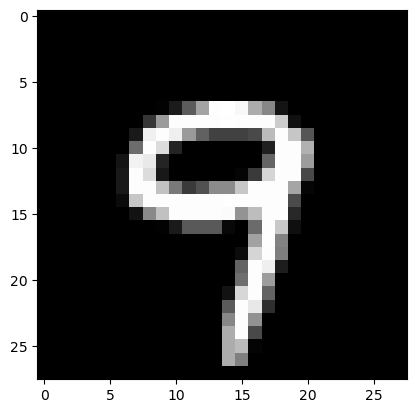

In [18]:
# Let's Visualize some examples
i = 10
print(f"Number: {int(label[i])}\n")

plt.imshow(image[i], cmap='gray')
plt.show()

In [12]:
num_classes = 10

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(32, (5,5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(strides=(2,2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

/Users/aayushgambhir/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
epochs = 5

# Define EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

# Assuming you have already defined and compiled your model
history = model.fit(
    train,
    epochs=epochs,
    validation_data=test,
    callbacks=[early_stopping]
)

Epoch 1/5


/Users/aayushgambhir/anaconda3/lib/python3.11/site-packages/keras/src/backend/tensorflow/nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


469/469 ━━━━━━━━━━━━━━━━━━━━ 226s 478ms/step - loss: 0.5457 - sparse_categorical_accuracy: 0.8210 - val_loss: 0.0409 - val_sparse_categorical_accuracy: 0.9869
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 282s 522ms/step - loss: 0.0802 - sparse_categorical_accuracy: 0.9765 - val_loss: 0.0365 - val_sparse_categorical_accuracy: 0.9891
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 281s 598ms/step - loss: 0.0615 - sparse_categorical_accuracy: 0.9829 - val_loss: 0.0279 - val_sparse_categorical_accuracy: 0.9910
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 309s 659ms/step - loss: 0.0480 - sparse_categorical_accuracy: 0.9866 - val_loss: 0.0257 - val_sparse_categorical_accuracy: 0.9916
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 237s 506ms/step - loss: 0.0406 - sparse_categorical_accuracy: 0.9883 - val_loss: 0.0206 - val_sparse_categorical_accuracy: 0.9935


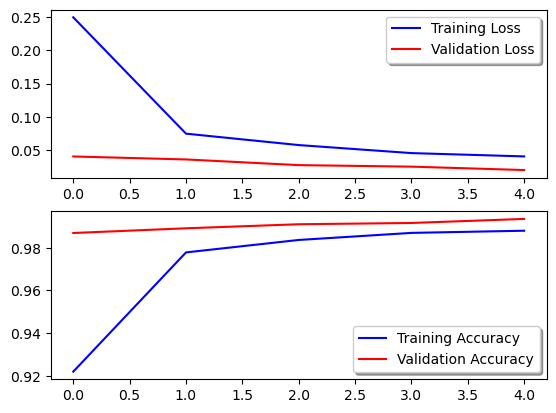

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['sparse_categorical_accuracy'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_sparse_categorical_accuracy'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)